In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt


生成数据

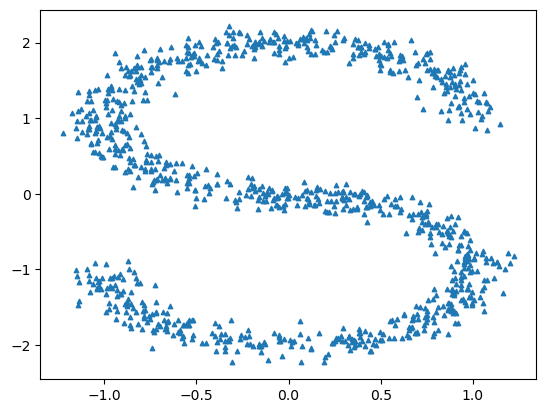

In [2]:
from sklearn.datasets import make_s_curve

DATASET_SIZE = 1000

x, _ = make_s_curve(n_samples=DATASET_SIZE, noise=0.1)
data = x[:, [0, 2]]

plt.scatter(*data.T, s=10, marker='^')

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.Tensor(data)
        self.len = len(data)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data[idx]

dataset = MyDataset(data)


前向过程参数设置

In [4]:
NUM_STEP = 100
betas = torch.linspace(0.0001, 0.02, NUM_STEP)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, dim=0)
alphas_bar_sqrt = alphas_bar.sqrt()
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_bar)

betas.shape, alphas.shape, alphas_bar.shape, one_minus_alphas_bar_sqrt.shape

(torch.Size([100]), torch.Size([100]), torch.Size([100]), torch.Size([100]))

In [5]:
def get_x_t(x_0: torch.Tensor, t: int or torch.Tensor, e_t: torch.Tensor):
    """
    前向函数
    从 x_0 得到 x_(t+1)（注意下标取值）
    """
    t = t.unsqueeze(-1)
    x_t = alphas_bar_sqrt[t] * x_0 + one_minus_alphas_bar_sqrt[t] * e_t
    return x_t


In [24]:
class DiffusionNet(nn.Module):
    def __init__(self, input_dim: int, num_steps: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.embedding1 = nn.Embedding(num_steps, 16)
        self.fc23 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        hidden = torch.cat([self.fc1(x), self.embedding1(t)], dim=1)
        return self.fc23(hidden)

net = DiffusionNet(input_dim=2, num_steps=NUM_STEP)

训练准备

In [35]:
batch_size = 10
lr = 1e-4
epochs = 1000

loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
mse = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr)


In [36]:
for epoch in range(epochs):
    sum_loss = 0.0
    cnt = 0

    for x_0 in loader:
        optimizer.zero_grad()
        t = torch.randint(0, NUM_STEP, size=(batch_size, )).long()
        e_t = torch.randn_like(x_0)
        x_t = get_x_t(x_0, t, e_t)
        e_hat = net(x_t, t)
        loss = mse(e_hat, e_t)
        loss.backward()
        optimizer.step()

        sum_loss += float(loss)
        cnt += 1
    
    with torch.no_grad():
        print("Epoch {}, avg loss {}".format(epoch + 1, sum_loss / cnt))


Epoch 1, avg loss 0.5901374877989292
Epoch 2, avg loss 0.6330828085541725
Epoch 3, avg loss 0.5785306957364083
Epoch 4, avg loss 0.5879452599585057
Epoch 5, avg loss 0.6428382767736912
Epoch 6, avg loss 0.6562807758152485
Epoch 7, avg loss 0.6639983193576335
Epoch 8, avg loss 0.646080025434494
Epoch 9, avg loss 0.6656650084257126
Epoch 10, avg loss 0.6238264721632004
Epoch 11, avg loss 0.5998506906628609
Epoch 12, avg loss 0.6301404449343682
Epoch 13, avg loss 0.5855943223834038
Epoch 14, avg loss 0.6255754667520523
Epoch 15, avg loss 0.6899197050929069
Epoch 16, avg loss 0.6385319666564464
Epoch 17, avg loss 0.6228739047050476
Epoch 18, avg loss 0.6692814454436302
Epoch 19, avg loss 0.6366777761280537
Epoch 20, avg loss 0.6869285017251968
Epoch 21, avg loss 0.6196815432608127
Epoch 22, avg loss 0.6721068280935287
Epoch 23, avg loss 0.6155301705002785
Epoch 24, avg loss 0.662044095993042
Epoch 25, avg loss 0.6248309782147408
Epoch 26, avg loss 0.6436248788237572
Epoch 27, avg loss 0.63

In [9]:
torch.save(net, "./net.pkl")

In [37]:
def generate(num: int) -> torch.Tensor:
    """
    生成新的样本
    """
    net.eval()
    x_t = torch.randn(num, 2)
    for t in reversed(range(NUM_STEP)):
        t = t * torch.ones(num).long()
        e_hat = net(x_t, t)
        t.unsqueeze_(-1)
        mean = 1 / alphas[t].sqrt() * (x_t - betas[t] / one_minus_alphas_bar_sqrt[t] * e_hat)
        z_bar_t = torch.randn(num, 2)
        x_t = mean + betas[t] * z_bar_t
    return x_t.detach().numpy()

In [38]:
samples = generate(1000)
samples

array([[ 0.8328846 , -0.45715317],
       [-0.3068756 ,  0.14597215],
       [-0.5986671 , -1.762388  ],
       ...,
       [-0.93506193,  0.7451139 ],
       [ 0.06014497, -0.00273982],
       [ 0.6333057 , -0.21415068]], dtype=float32)

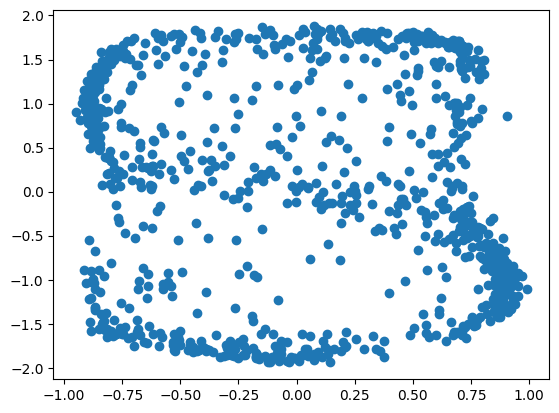

In [34]:
plt.scatter(*samples.T)